# Price Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import ttest_ind
import datetime

## 1. Load Data

In [2]:
test_table = pd.read_csv('test_results.csv')
user_table = pd.read_csv('user_table.csv')

In [3]:
test_table.info()
test_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user_table.info()
user_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


## 2. Missing Data

In [5]:
pd.isnull(test_table).sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [6]:
pd.isnull(user_table).sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

* There is no missing data in two datasets.

## 3. Data Processing

In [7]:
#merge the two tables by user_id
data = test_table.merge(user_table, how='left',on="user_id")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316800 non-null  int64  
 1   timestamp         316800 non-null  object 
 2   source            316800 non-null  object 
 3   device            316800 non-null  object 
 4   operative_system  316800 non-null  object 
 5   test              316800 non-null  int64  
 6   price             316800 non-null  int64  
 7   converted         316800 non-null  int64  
 8   city              275616 non-null  object 
 9   country           275616 non-null  object 
 10  lat               275616 non-null  float64
 11  long              275616 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 31.4+ MB


In [8]:
#check the uniquess of two tables
print('user_table:\t',user_table['user_id'].unique().shape)
print('test_table:\t',test_table['user_id'].unique().shape)

user_table:	 (275616,)
test_table:	 (316800,)


In [9]:
#check the number of observations in different groups
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [10]:
#look at the control group with price 59
control_price_diff = data[(data['test']==0) & (data['price']==59)]
control_price_diff[['converted','user_id']].groupby(['converted']).count()

,user_id
converted,
0,205
1,5


In [11]:
#look at the test group with price 39
test_price_diff = data[(data['test']==1) & (data['price']==39)]
test_price_diff[['converted','user_id']].groupby(['converted']).count()

,user_id
converted,
0,154
1,1


It seems that there are some problems with the data:  
1, There are users who saw price 59 in control group, which only 5 of 210 converted.  
2, There are users who saw price 39 in test group, which only 1 of 155 converted.  
   
Since they are only small portion of the whole dataset, we just dropped these data.

In [12]:
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

Since we want to look at the profitability with different price, so we want to not only see conversion rate but also the revenue. So we add a new column revenue which is the product of converted and price.

In [13]:
#create new column called `revenue`
data['revenue'] = data['converted'] * data['price']

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 0 to 316799
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316435 non-null  int64  
 1   timestamp         316435 non-null  object 
 2   source            316435 non-null  object 
 3   device            316435 non-null  object 
 4   operative_system  316435 non-null  object 
 5   test              316435 non-null  int64  
 6   price             316435 non-null  int64  
 7   converted         316435 non-null  int64  
 8   city              275294 non-null  object 
 9   country           275294 non-null  object 
 10  lat               275294 non-null  float64
 11  long              275294 non-null  float64
 12  revenue           316435 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 33.8+ MB


## 4. Visualize the distribution, conversion rate and mean revenue for differenct groups

### 4.1 test and control group

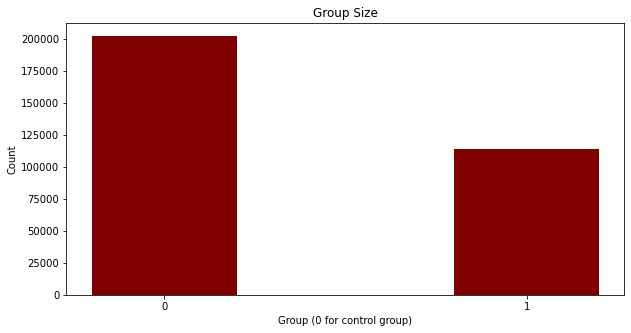

In [15]:
df = pd.DataFrame(data.groupby(['test'])['user_id'].count()).reset_index()
df['test'] = df['test'].astype('str')
#plot
fig = plt.figure(figsize = (10, 5)) 
plt.bar(df['test'], df['user_id'], color ='maroon',  
        width = 0.4) 
  
plt.xlabel('Group (0 for control group)') 
plt.ylabel('Count') 
plt.title('Group Size') 
plt.show()

* There is more observations in control group than test group.

In [16]:
tmp_control = data[(data['test']==0)].groupby('converted')['user_id'].count()
control_rate = tmp_control.iloc[1]/(tmp_control.iloc[1]+tmp_control.iloc[0])
tmp_test = data[(data['test']==1)].groupby('converted')['user_id'].count()
test_rate = tmp_test.iloc[1]/(tmp_test.iloc[1]+tmp_test.iloc[0])
tmp = pd.DataFrame({"test":[0,1], "conversion_rate":[control_rate,test_rate]})
print(tmp)

   test  conversion_rate
0     0         0.019900
1     1         0.015555


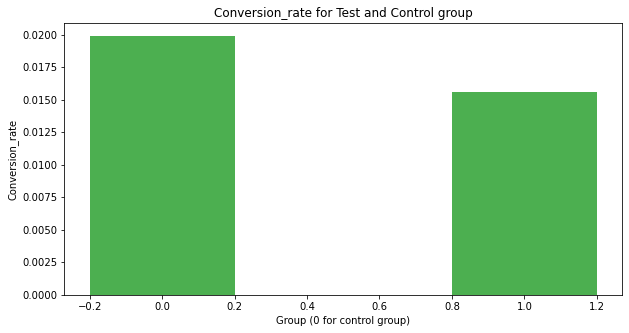

In [17]:
#plot
fig = plt.figure(figsize = (10, 5)) 
plt.bar(tmp['test'], tmp['conversion_rate'], color ='#4CAF50',  
        width = 0.4) 
  
plt.xlabel('Group (0 for control group)') 
plt.ylabel('Conversion_rate') 
plt.title('Conversion_rate for Test and Control group') 
plt.show()

* The conversion rate for control group is higher than the test group.

In [18]:
mean_rev_control = data[(data['test']==0)]['revenue'].sum()/data[(data['test']==0)]['user_id'].count()
mean_rev_test = data[(data['test']==1)]['revenue'].sum()/data[(data['test']==1)]['user_id'].count()
tmp = pd.DataFrame({"test":[0,1], "mean_rev":[mean_rev_control,mean_rev_test]})
print(tmp)

   test  mean_rev
0     0  0.776083
1     1  0.917748


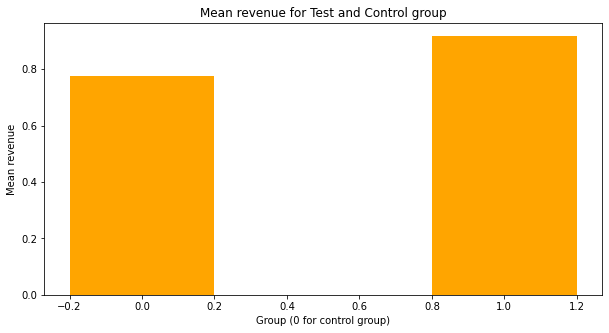

In [19]:
#plot
fig = plt.figure(figsize = (10, 5)) 
plt.bar(tmp['test'], tmp['mean_rev'], color ='orange',  
        width = 0.4) 
  
plt.xlabel('Group (0 for control group)') 
plt.ylabel('Mean revenue') 
plt.title('Mean revenue for Test and Control group') 
plt.show()

* But the mean revenue for control group is lower. 

### 4.2 source group

In [20]:
df = data.groupby(['test','source'])['user_id'].count()
df = pd.concat([df[0].apply(lambda x:x/sum(df[0])),df[1].apply(lambda x:x/sum(df[1]))],keys=['0','1'],axis=1).T

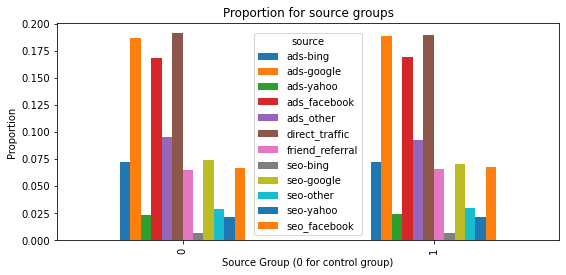

In [21]:
#plot
fig,ax = plt.subplots(figsize=(9,4))
df.plot(kind='bar', ax=ax)
plt.xlabel('Source Group (0 for control group)') 
plt.ylabel('Proportion') 
plt.title('Proportion for source groups') 
plt.show() 

* There is no big difference in source distributions of control and test. We can conclude that the sample is selected randomly.

In [22]:
tmp_control = data[(data['test']==0)].groupby(['source','converted'])['user_id'].count()
rate = []
for i in [0,2,4,6,8,10,12,14,16,18,20,22]:
    rate.append(tmp_control.iloc[i+1]/(tmp_control.iloc[i]+tmp_control.iloc[i+1]))
rate = pd.DataFrame(rate)
source = pd.DataFrame(tmp_control.index.get_level_values('source').unique())
tmp_control = pd.concat([source,rate],axis=1)
tmp_control

,source,0
0,ads-bing,0.013371
1,ads-google,0.022566
2,ads-yahoo,0.016833
3,ads_facebook,0.023654
4,ads_other,0.015424
5,direct_traffic,0.013510
6,friend_referral,0.041689
7,seo-bing,0.030098
8,seo-google,0.017497
9,seo-other,0.017520


In [23]:
tmp_test = data[(data['test']==1)].groupby(['source','converted'])['user_id'].count()
rate = []
for i in [0,2,4,6,8,10,12,14,16,18,20,22]:
    rate.append(tmp_test.iloc[i+1]/(tmp_test.iloc[i]+tmp_test.iloc[i+1]))
rate = pd.DataFrame(rate)
source = pd.DataFrame(tmp_test.index.get_level_values('source').unique())
tmp_test = pd.concat([source,rate],axis=1)
tmp_test

,source,0
0,ads-bing,0.009579
1,ads-google,0.019631
2,ads-yahoo,0.011236
3,ads_facebook,0.016856
4,ads_other,0.012394
5,direct_traffic,0.010111
6,friend_referral,0.033479
7,seo-bing,0.013497
8,seo-google,0.016005
9,seo-other,0.012481


In [24]:
tmp = tmp_control.merge(tmp_test, on='source')
tmp.columns = ['source','0', '1']
tmp

,source,0,1
0,ads-bing,0.013371,0.009579
1,ads-google,0.022566,0.019631
2,ads-yahoo,0.016833,0.011236
3,ads_facebook,0.023654,0.016856
4,ads_other,0.015424,0.012394
5,direct_traffic,0.013510,0.010111
6,friend_referral,0.041689,0.033479
7,seo-bing,0.030098,0.013497
8,seo-google,0.017497,0.016005
9,seo-other,0.017520,0.012481


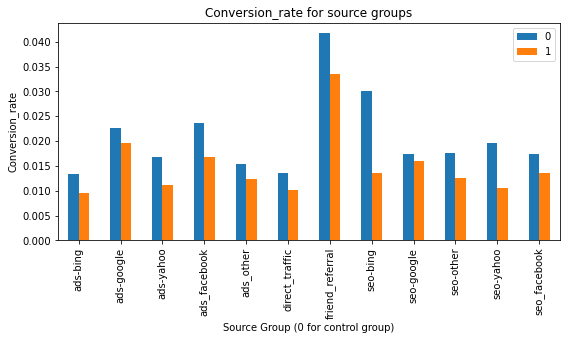

In [25]:
#plot
tmp.plot(x="source", y=["0", "1"], kind="bar",figsize=(9,4))
plt.xlabel('Source Group (0 for control group)') 
plt.ylabel('Conversion_rate') 
plt.title('Conversion_rate for source groups') 
plt.show() 

* For both control and test, the source, friend_referral has the hightest conversion rate.  
* The conversion rate of control group is constantly higher than that of the test group.
* The biggest difference is in search on bing group.

In [26]:
mean_rev_control = pd.DataFrame(data[(data['test']==0)].groupby(['source'])['revenue'].sum()/data[(data['test']==0)].groupby(['source'])['user_id'].count())
mean_rev_test = pd.DataFrame(data[(data['test']==1)].groupby(['source'])['revenue'].sum()/data[(data['test']==1)].groupby(['source'])['user_id'].count())
tmp = mean_rev_control.merge(mean_rev_test, on='source').reset_index()
tmp.columns = ['source','0','1']

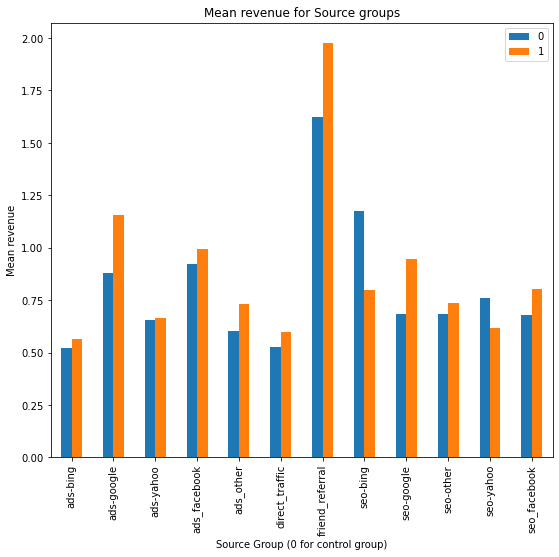

In [27]:
#plot
tmp.plot(x="source", y=["0", "1"], kind="bar",figsize=(9,8))
plt.xlabel('Source Group (0 for control group)') 
plt.ylabel('Mean revenue') 
plt.title('Mean revenue for Source groups') 
plt.show()

* For both control and test, the source, friend_referral has the hightest mean revenue.  
* For search in bing and search in yahoo groups, the mean revenue for test group is lower than the control group, which is abnormal.  
* The big difference occurs in ads-google, friend_referral, and search in google.

### 4.3 device group

In [28]:
df = data.groupby(['test','device'])['user_id'].count()
df = pd.concat([df[0].apply(lambda x:x/sum(df[0])),df[1].apply(lambda x:x/sum(df[1]))],keys=['0','1'],axis=1).T

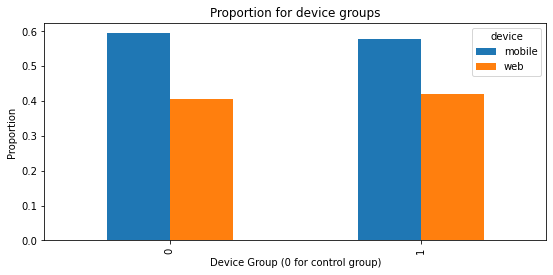

In [29]:
#plot
fig,ax = plt.subplots(figsize=(9,4))
df.plot(kind='bar', ax=ax)
plt.xlabel('Device Group (0 for control group)') 
plt.ylabel('Proportion') 
plt.title('Proportion for device groups') 
plt.show() 

* There is no big difference in distribution.

In [30]:
tmp_control = data[(data['test']==0)].groupby(['device','converted'])['user_id'].count()
rate = []
for i in [0,2]:
    rate.append(tmp_control.iloc[i+1]/(tmp_control.iloc[i]+tmp_control.iloc[i+1]))
rate = pd.DataFrame(rate)
device = pd.DataFrame(tmp_control.index.get_level_values('device').unique())
tmp_control = pd.concat([device,rate],axis=1)
tmp_control

,device,0
0,mobile,0.019872
1,web,0.019940


In [31]:
tmp_test = data[(data['test']==1)].groupby(['device','converted'])['user_id'].count()
rate = []
for i in [0,2]:
    rate.append(tmp_test.iloc[i+1]/(tmp_test.iloc[i]+tmp_test.iloc[i+1]))
rate = pd.DataFrame(rate)
device = pd.DataFrame(tmp_test.index.get_level_values('device').unique())
tmp_test = pd.concat([device,rate],axis=1)
tmp_test

,device,0
0,mobile,0.016146
1,web,0.014744


In [32]:
tmp = tmp_control.merge(tmp_test, on='device')
tmp.columns = ['device','0', '1']
tmp

,device,0,1
0,mobile,0.019872,0.016146
1,web,0.019940,0.014744


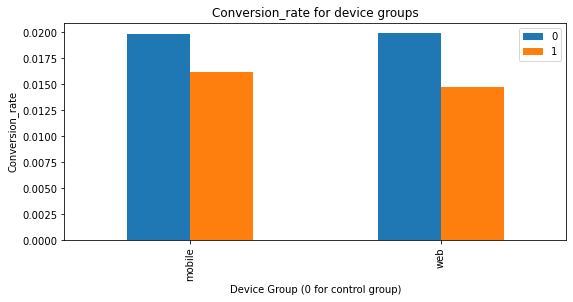

In [33]:
#plot
tmp.plot(x="device", y=["0", "1"], kind="bar",figsize=(9,4))
plt.xlabel('Device Group (0 for control group)') 
plt.ylabel('Conversion_rate') 
plt.title('Conversion_rate for device groups') 
plt.show() 

* For both mobile and web, the conversion rate of control is higher than test.
* There is no big difference betwenn mobile and web.

In [34]:
mean_rev_control = pd.DataFrame(data[(data['test']==0)].groupby(['device'])['revenue'].sum()/data[(data['test']==0)].groupby(['device'])['user_id'].count())
mean_rev_test = pd.DataFrame(data[(data['test']==1)].groupby(['device'])['revenue'].sum()/data[(data['test']==1)].groupby(['device'])['user_id'].count())
tmp = mean_rev_control.merge(mean_rev_test, on='device').reset_index()
tmp.columns = ['device','0','1']

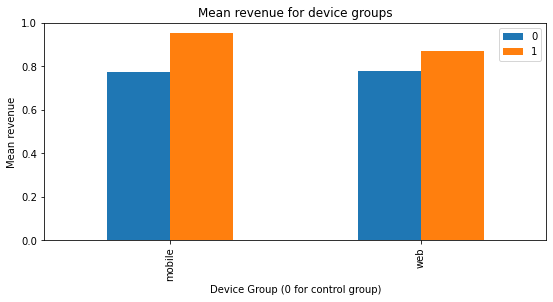

In [35]:
#plot
tmp.plot(x="device", y=["0", "1"], kind="bar",figsize=(9,4))
plt.xlabel('Device Group (0 for control group)') 
plt.ylabel('Mean revenue') 
plt.title('Mean revenue for device groups') 
plt.show()

* For both mobile and web, the mean revenue of test is a little higher.  
* The bigger difference is in mobile.

### 4.4 operative_system

In [36]:
df = data.groupby(['test','operative_system'])['user_id'].count()
df = pd.concat([df[0].apply(lambda x:x/sum(df[0])),df[1].apply(lambda x:x/sum(df[1]))],keys=['0','1'],axis=1).T

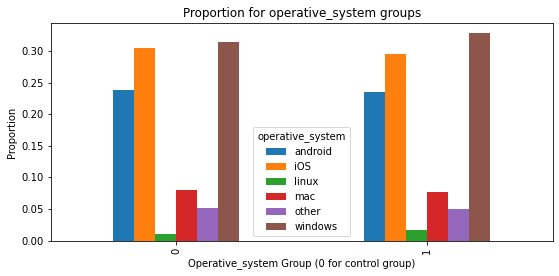

In [37]:
#plot
fig,ax = plt.subplots(figsize=(9,4))
df.plot(kind='bar', ax=ax)
plt.xlabel('Operative_system Group (0 for control group)') 
plt.ylabel('Proportion') 
plt.title('Proportion for operative_system groups') 
plt.show() 

* No big diff in distribution.

In [38]:
tmp_control = data[(data['test']==0)].groupby(['operative_system','converted'])['user_id'].count()
rate = []
for i in [0,2,4,6,8,10]:
    rate.append(tmp_control.iloc[i+1]/(tmp_control.iloc[i]+tmp_control.iloc[i+1]))
rate = pd.DataFrame(rate)
operative_system = pd.DataFrame(tmp_control.index.get_level_values('operative_system').unique())
tmp_control = pd.concat([operative_system,rate],axis=1)
tmp_control

,operative_system,0
0,android,0.016336
1,iOS,0.023595
2,linux,0.015426
3,mac,0.025451
4,other,0.014025
5,windows,0.018704


In [39]:
tmp_test = pd.DataFrame(data[(data['test']==1)].groupby(['operative_system','converted'])['user_id'].count())
tmp_test.loc[('linux',1),:] = (0)
tmp_test = tmp_test.sort_values('operative_system')
rate = []
for i in [0,2,4,6,8,10]:
    rate.append(tmp_test.iloc[i+1]/(tmp_test.iloc[i]+tmp_test.iloc[i+1]))
rate = pd.DataFrame(rate)
operative_system = pd.DataFrame(tmp_test.index.get_level_values('operative_system').unique())
tmp_test = pd.concat([operative_system,rate],axis=1)
tmp_test

,operative_system,user_id
0,android,0.012363
1,iOS,0.019994
2,linux,0.000000
3,mac,0.021240
4,other,0.011060
5,windows,0.014009


In [40]:
tmp = tmp_control.merge(tmp_test, on='operative_system')
tmp.columns = ['operative_system','0', '1']
tmp

,operative_system,0,1
0,android,0.016336,0.012363
1,iOS,0.023595,0.019994
2,linux,0.015426,0.000000
3,mac,0.025451,0.021240
4,other,0.014025,0.011060
5,windows,0.018704,0.014009


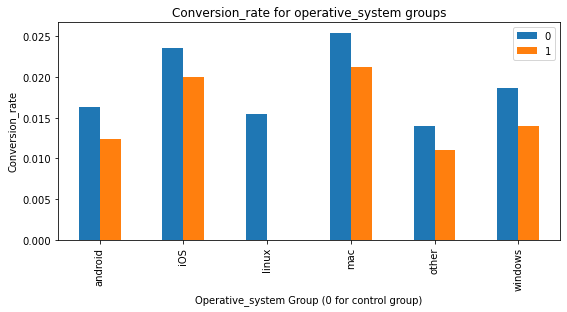

In [41]:
#plot
tmp.plot(x="operative_system", y=["0", "1"], kind="bar",figsize=(9,4))
plt.xlabel('Operative_system Group (0 for control group)') 
plt.ylabel('Conversion_rate') 
plt.title('Conversion_rate for operative_system groups') 
plt.show() 

* The converion rate in test group of linux is 0.  
* For the rest of all operative_system groups, conversion rate is lower in test group.  
* Mac users have the highest conversion rate for both test and control.

In [42]:
mean_rev_control = pd.DataFrame(data[(data['test']==0)].groupby(['operative_system'])['revenue'].sum()/data[(data['test']==0)].groupby(['operative_system'])['user_id'].count())
mean_rev_test = pd.DataFrame(data[(data['test']==1)].groupby(['operative_system'])['revenue'].sum()/data[(data['test']==1)].groupby(['operative_system'])['user_id'].count())
tmp = mean_rev_control.merge(mean_rev_test, on='operative_system').reset_index()
tmp.columns = ['operative_system','0','1']

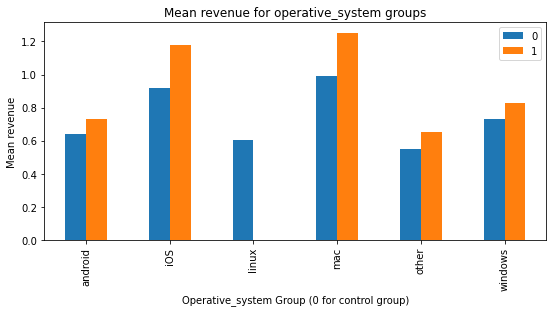

In [43]:
#plot
tmp.plot(x="operative_system", y=["0", "1"], kind="bar",figsize=(9,4))
plt.xlabel('Operative_system Group (0 for control group)') 
plt.ylabel('Mean revenue') 
plt.title('Mean revenue for operative_system groups') 
plt.show()

* The mean revenue in linux of test group is 0.  
* Mac and IOS users have higher mean revenue than others.

## 5. Question

### 5.1 Question1: Should the company sell its software for 39 or 59?

As we know, the convertion rate for control group is higher than test group. However, since we want to increase the revenue, so we would like to do the hypothesis text on the revenue for two groups. 

* Null hypothesis: the price 39 is more or equal on the average revenue comparing with 59.  
* Alternative hypothesis: the price 39 is less on the average revenue comparing with 59.

In [44]:
ctr_val = data[data['test'] == 0]['revenue'].values
tet_val = data[data['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, tet_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


Conclusion: The p-value is super small so we can reject the null hypothesis, which means that the price 39 is less on the average revenue comparing with 59 on a significant level. The company should sell its software for 59. 

However, we also know that the high price will decrease the conversion rate, we would like to see what can help increase the conversion rate.

### 5.2 Question2: How to increase conversion rate?

From previous hypothesis test, we can increase the price to 50 to gain more revenue.   
Meanwhile, in order to keep a relatively higher conversion rate, we found that friend_referral, mac and IOS user are doing good in test group conversion rate.   
So we can choose the strategy influencing these factors:  
1, launch specific project to attract more users to invite there friends, such as giving rewards or discount for referral.  
2, since both the number of user and conversion rate is high for IOS users, can consider do more marketing program program on IOS users.  
   or, can do different pricing on different system users depending on their puchase power.

The last thing we need to consider is that our software may have some incompatibility in linux system, so the conversion rate of test group was 0.

## 5.3 Question3: After how many days you would have stopped the test?

In [45]:
print('start time:',data['timestamp'].min())
print('stop time:',data['timestamp'].max())

start time: 2015-03-02 00:04:12
stop time: 2015-05-31 23:59:45


In [46]:
#only keep date time
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['date'] = data['timestamp'].dt.date

In [47]:
conversion_by_date = pd.DataFrame(data.groupby(['date','test'])['converted'].mean())
conversion_by_date = conversion_by_date.reset_index()

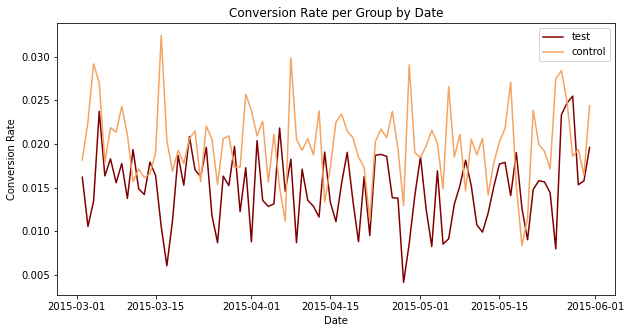

In [48]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(conversion_by_date[conversion_by_date.test==1].date, conversion_by_date[conversion_by_date.test==1].converted,\
         color ='maroon',label = "test")
plt.plot(conversion_by_date[conversion_by_date.test==0].date, conversion_by_date[conversion_by_date.test==0].converted,\
         color = 'sandybrown',label = "control")
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Group by Date')
plt.legend()
plt.show()

In [49]:
data['month'] = pd.to_datetime(data.date).dt.month
data['week'] = pd.to_datetime(data.date).dt.week

In [50]:
conversion_by_week = pd.DataFrame(data.groupby(['week','test'])['converted'].mean())
conversion_by_week = conversion_by_week.reset_index()

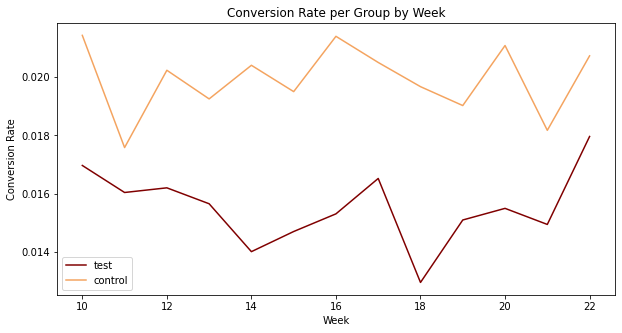

In [51]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(conversion_by_week[conversion_by_week.test==1].week, conversion_by_week[conversion_by_week.test==1].converted,\
         color ='maroon',label = "test")
plt.plot(conversion_by_week[conversion_by_week.test==0].week, conversion_by_week[conversion_by_week.test==0].converted,\
         color = 'sandybrown',label = "control")
plt.xlabel('Week')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Group by Week')
plt.legend()
plt.show()

In [52]:
conversion_by_month = pd.DataFrame(data.groupby(['month','test'])['converted'].mean())
conversion_by_month = conversion_by_month.reset_index()

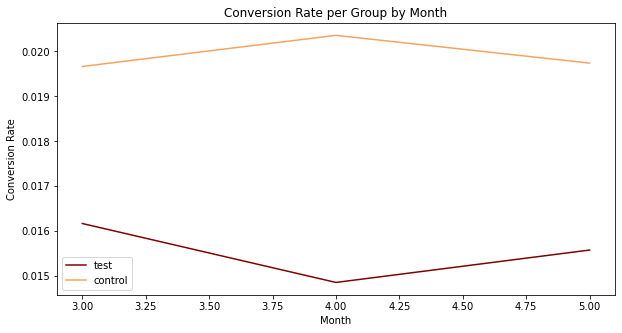

In [53]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(conversion_by_month[conversion_by_month.test==1].month, conversion_by_month[conversion_by_month.test==1].converted,\
         color ='maroon',label = "test")
plt.plot(conversion_by_month[conversion_by_month.test==0].month, conversion_by_month[conversion_by_month.test==0].converted,\
         color = 'sandybrown',label = "control")
plt.xlabel('Month')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Group by Month')
plt.legend()
plt.show()

* According to above time trend for conversion rate, may decrease the testing period to one-month, which is sufficient to get enough user information.  
* Do Power Analysis.